In [50]:
# Импортируем только самое необходимое:) 
import pandas as pd

import numpy as np
from numpy import mean
from numpy import ravel
from numpy import log

import matplotlib.pyplot as plt
import seaborn as sns

import joblib
import re
import sklearn

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import GridSearchCV
from skopt import BayesSearchCV

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

import xgboost as xgb
from xgboost import XGBClassifier

from catboost import CatBoostClassifier

from category_encoders import TargetEncoder

# Preprocessing

In [51]:
# Выгружаем данные, наслаждаемся видом
default_df = pd.read_csv('/home/ni/My Projects/Uralsib_test/data.txt',delimiter=';')
default_df

,Месяц выдачи кредита,Сумма кредита,Срок кредита,Возраст клиента,Пол клиента,Образование клиента,Тип товара,Наличие детей у клиента,Регион выдачи кредита,Доход клиента,Семейное положение,Оператор связи,Является ли клиентом банка,Флаг дефолта по кредиту
0,1,7000,12,39,Мужской,Среднее специальное,Мобильные телефоны,Детей нет,Другие регионы,21000,Другое,МТС,Не клиент банка,Нет дефолта
1,1,19000,6,20,Мужской,Среднее специальное,Бытовая техника,Дети есть,Другие регионы,17000,Другое,Теле2,Клиент банка,Нет дефолта
2,1,29000,12,23,Женский,Среднее специальное,Бытовая техника,Детей нет,Другие регионы,31000,Другое,Билайн,Не клиент банка,Нет дефолта
3,1,10000,12,30,Мужской,Среднее специальное,Мобильные телефоны,Дети есть,Другие регионы,31000,Никогда не был(а) женат/замужем,Теле2,Клиент банка,Нет дефолта
4,1,14500,12,25,Женский,Высшее,Мобильные телефоны,Детей нет,Другие регионы,26000,Женат/замужем,МТС,Клиент банка,Нет дефолта
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1718,12,18500,6,32,Мужской,Высшее,Мобильные телефоны,Дети есть,Другие регионы,46000,Другое,Мегафон,Клиент банка,Нет дефолта
1719,12,6500,6,24,Мужской,Среднее специальное,Мобильные телефоны,Детей нет,Другие регионы,18000,Другое,МТС,Клиент банка,Нет дефолта
1720,12,5500,12,21,Мужской,Неоконченное высшее,Мобильные телефоны,Детей нет,Другие регионы,15000,Другое,Мегафон,Клиент банка,Нет дефолта
1721,12,30500,10,25,Женский,Неоконченное высшее,Мобильные телефоны,Детей нет,Другие регионы,41000,Другое,Билайн,Клиент банка,Дефолт


In [52]:
# Восхищаемся сбалансированностью
default_df['Флаг дефолта по кредиту'].value_counts()

Нет дефолта    1527
Дефолт          196
Name: Флаг дефолта по кредиту, dtype: int64

In [53]:
# Проверяем нет ли пропусков
default_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1723 entries, 0 to 1722
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Месяц выдачи кредита        1723 non-null   int64 
 1   Сумма кредита               1723 non-null   int64 
 2   Срок кредита                1723 non-null   int64 
 3   Возраст клиента             1723 non-null   int64 
 4   Пол клиента                 1723 non-null   object
 5   Образование клиента         1723 non-null   object
 6   Тип товара                  1723 non-null   object
 7   Наличие детей у клиента     1723 non-null   object
 8   Регион выдачи кредита       1723 non-null   object
 9   Доход клиента               1723 non-null   int64 
 10  Семейное положение          1723 non-null   object
 11  Оператор связи              1723 non-null   object
 12  Является ли клиентом банка  1723 non-null   object
 13  Флаг дефолта по кредиту     1723 non-null   obje

In [54]:
# Логорифмируем большие числовые значения
default_df['Сумма кредита'] = log(default_df['Сумма кредита'])

In [55]:
default_df['Доход клиента'] = log(default_df['Доход клиента'])

### Добавляем новые фичи

In [56]:
# Делаем словарь с сезонами по месяцам
seasons = {
    'Зима': (12, 1, 2),
    'Весна': (3, 4, 5),
    'Лето': (6, 7, 8),
    'Осень': (9, 10, 11)
}

In [57]:
# Назначаем функцию для создания колонки "Сезон"
def get_season(value):
    for k, v in seasons.items():
        if value in v:
            return k

In [58]:
# Добавляем сезон
default_df['Сезон'] = default_df['Месяц выдачи кредита'].apply(get_season)

In [59]:
# Добавляем долю кредита от дохода
default_df['Доля кредита от дохода'] = (default_df['Сумма кредита'] / default_df['Срок кредита']) / default_df['Доход клиента']

In [60]:
pd.crosstab(default_df['Образование клиента'], default_df['Флаг дефолта по кредиту'])

Флаг дефолта по кредиту,Дефолт,Нет дефолта
Образование клиента,,
Высшее,35,550
Неоконченное высшее,5,81
Неоконченное среднее,0,5
Несколько высших или более высокая ступень образования,0,3
Среднее,40,168
Среднее специальное,116,720


In [61]:
# Добавляем образованность
default_df['Образованность'] = ['Среднее' if row == 'Среднее' or row == 'Неоконченное среднее' else 'Выше среднего' for row in default_df['Образование клиента']]

In [62]:
pd.crosstab(default_df['Тип товара'], default_df['Флаг дефолта по кредиту'])

Флаг дефолта по кредиту,Дефолт,Нет дефолта
Тип товара,,
Автомобильные товары,3,18
"Аудио, Видео, Фото",0,9
Бытовая техника,36,435
"Детские товары (игрушки, детская одежда, детская мебель)",0,2
"Компьютеры, комплектующие",8,170
Косметика и косметические услуги,5,50
Мебель,8,156
Медицинские услуги,1,26
Мобильные телефоны,113,385


In [63]:
# Телефон \ не телефон
default_df['Товар'] = ['Мобильный' if row == 'Мобильные телефоны' else 'Не мобильный' for row in default_df['Тип товара']]

## Обозначаем числовые и категориальные фичи

In [64]:
# Числовые фичи
features = [
    'Доход клиента', 
    'Сумма кредита',
    'Возраст клиента',
    'Срок кредита',
    'Доля кредита от дохода'
]
# Категориальные
cat_features = [
    'Месяц выдачи кредита',
    'Пол клиента',
    'Образование клиента',
    'Тип товара',
    'Наличие детей у клиента',
    'Регион выдачи кредита',
    'Семейное положение',
    'Оператор связи',
    'Является ли клиентом банка',
    'Сезон',
    'Образованность',
    'Товар'
]

### Визуализация

Доход клиента


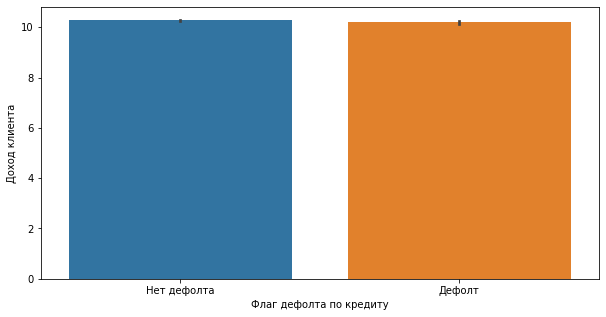

Сумма кредита


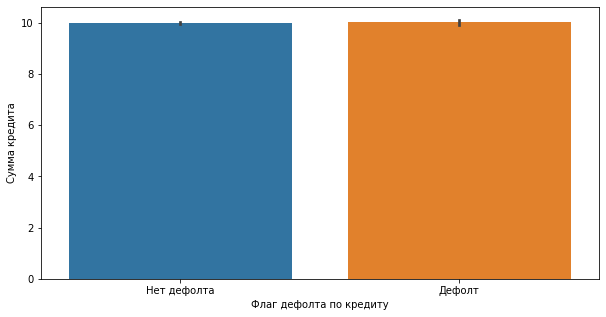

Возраст клиента


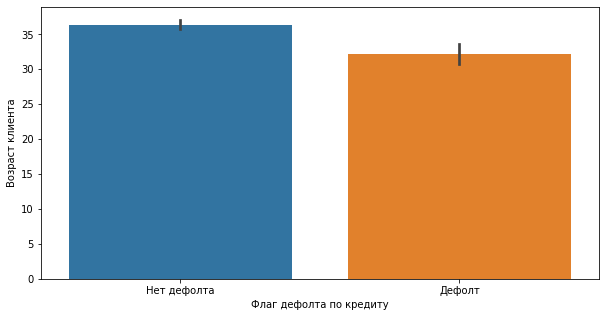

Срок кредита


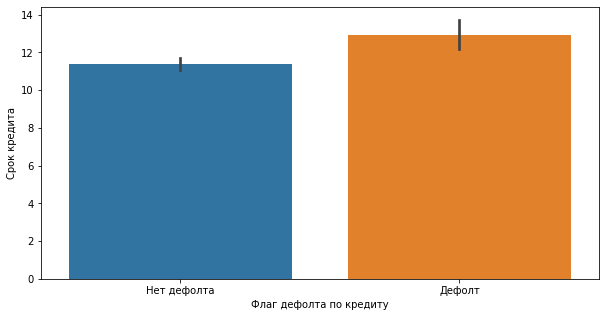

Доля кредита от дохода


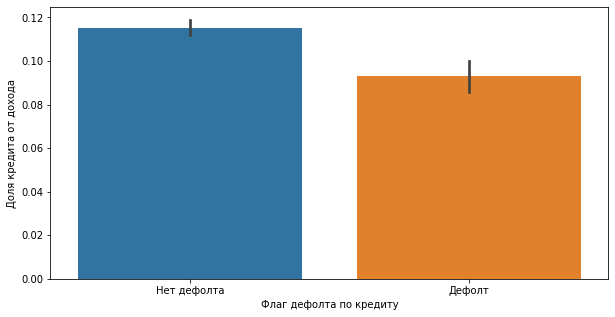

In [65]:
for feat in features:
    print(feat)
    plt.figure(figsize=(10,5))
    sns.barplot(x=default_df['Флаг дефолта по кредиту'], y=default_df[feat])
    plt.show()

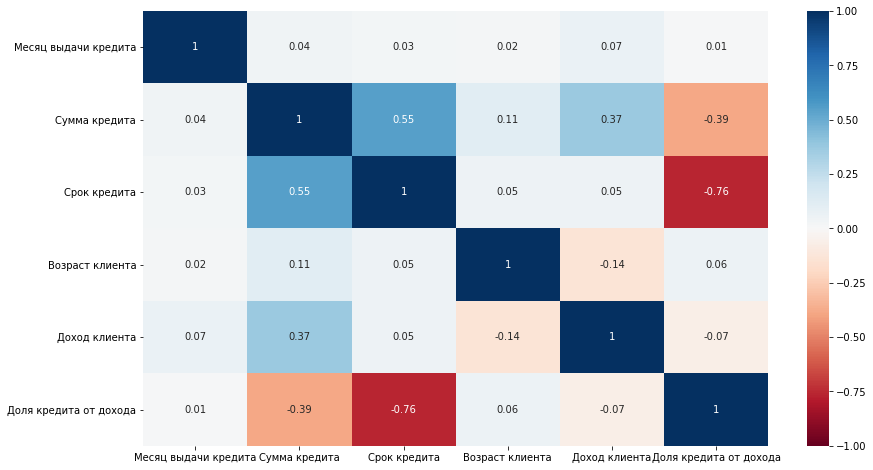

In [66]:
# Строим корреляционную матрицу по числовым фичам 
corr_matrix = default_df.corr().round(2)
figl, ax = plt.subplots(figsize=(14, 8))
sns.heatmap(corr_matrix, annot=True, cmap="RdBu", vmax=1, vmin=-1);

In [67]:
# Проводим факторизацию по целевой колонке и назначаем target
default_df['Флаг дефолта по кредиту'] = pd.factorize(default_df['Флаг дефолта по кредиту'])[0]
target=default_df['Флаг дефолта по кредиту']

### Пользуемся TargetEncoder

In [68]:
# Делаем новый df с Target Encoderом
TEncoded_default_df = TargetEncoder(cols=cat_features).fit_transform(default_df, default_df['Флаг дефолта по кредиту'])

/home/ni/.local/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [69]:
# Переименовываем колонки в новом df 
for col in TEncoded_default_df[cat_features]:
    TEncoded_default_df.rename(columns={col: f'Encoded {col}'}, inplace=True)

In [70]:
TEncoded_default_df

,Encoded Месяц выдачи кредита,Сумма кредита,Срок кредита,Возраст клиента,Encoded Пол клиента,Encoded Образование клиента,Encoded Тип товара,Encoded Наличие детей у клиента,Encoded Регион выдачи кредита,Доход клиента,Encoded Семейное положение,Encoded Оператор связи,Encoded Является ли клиентом банка,Флаг дефолта по кредиту,Encoded Сезон,Доля кредита от дохода,Encoded Образованность,Encoded Товар
0,0.136691,8.853665,12,39,0.085929,0.138756,0.226908,0.130964,0.120934,9.952278,0.104080,0.123134,0.074890,0,0.123007,0.074134,0.103311,0.226908
1,0.136691,9.852194,6,20,0.085929,0.138756,0.076433,0.090786,0.120934,9.740969,0.104080,0.101695,0.139155,0,0.123007,0.168570,0.103311,0.067755
2,0.136691,10.275051,12,23,0.146465,0.138756,0.076433,0.130964,0.120934,10.341742,0.104080,0.088328,0.074890,0,0.123007,0.082796,0.103311,0.067755
3,0.136691,9.210340,12,30,0.085929,0.138756,0.226908,0.090786,0.120934,10.341742,0.115385,0.101695,0.139155,0,0.123007,0.074217,0.103311,0.226908
4,0.136691,9.581904,12,25,0.146465,0.059829,0.226908,0.130964,0.120934,10.165852,0.139640,0.123134,0.139155,0,0.123007,0.078546,0.103311,0.226908
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1718,0.154321,9.825526,6,32,0.085929,0.059829,0.226908,0.090786,0.120934,10.736397,0.104080,0.121622,0.139155,0,0.123007,0.152527,0.103311,0.226908
1719,0.154321,8.779557,6,24,0.085929,0.138756,0.226908,0.130964,0.120934,9.798127,0.104080,0.123134,0.139155,0,0.123007,0.149341,0.103311,0.226908
1720,0.154321,8.612503,12,21,0.085929,0.058140,0.226908,0.130964,0.120934,9.615805,0.104080,0.121622,0.139155,0,0.123007,0.074638,0.103311,0.226908
1721,0.154321,10.325482,10,25,0.146465,0.058140,0.226908,0.130964,0.120934,10.621327,0.104080,0.088328,0.139155,1,0.123007,0.097215,0.103311,0.226908


In [71]:
default_df = pd.concat([default_df, TEncoded_default_df.drop(['Доход клиента', 
                          'Сумма кредита',
                          'Возраст клиента',
                          'Срок кредита',
                          'Доля кредита от дохода',
                          'Флаг дефолта по кредиту'
                         ], axis=1)], axis=1)

In [72]:
# Топорно докидываем Encoded колонки в features
features = [
    'Доход клиента', 
    'Сумма кредита',
    'Возраст клиента',
    'Срок кредита',
    'Доля кредита от дохода',
    'Encoded Месяц выдачи кредита',
    'Encoded Пол клиента',
    'Encoded Образование клиента',
    'Encoded Тип товара',
    'Encoded Наличие детей у клиента',
    'Encoded Регион выдачи кредита',
    'Encoded Семейное положение',
    'Encoded Оператор связи',
    'Encoded Является ли клиентом банка',
    'Encoded Сезон',
    'Encoded Образованность',
    'Encoded Товар'
]

In [73]:
# comment out когда используется CatBoost
for col in cat_features:
    if default_df[col].dtype == 'object':
        default_df[col] = pd.factorize(default_df[col])[0]

In [74]:
# Проводим факторизацию по целевой колонке и назначаем target
default_df['Флаг дефолта по кредиту'] = pd.factorize(default_df['Флаг дефолта по кредиту'])[0]
target=default_df['Флаг дефолта по кредиту']

## Normalising & Train Test Split

In [75]:
# Нормализация
scaler = StandardScaler()
normalised_default_df = scaler.fit_transform(default_df[features])

In [76]:
# Нормализорованные числовые фичи + категориальные фичи
default_list = np.concatenate([normalised_default_df, default_df[cat_features].values], axis=1)
default_list.shape
# для Catboost

(1723, 29)

In [77]:
# чтобы добавить исключения в catboost.fit
catboost_cat_features = np.arange(len(features), default_list.shape[1])

In [78]:
x_train, x_test, y_train, y_test = train_test_split(default_list, target, test_size=0.15)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((1464, 29), (259, 29), (1464,), (259,))

## Building CatBoost model

In [36]:
# Применяем GridSearhCV для более точной настройки параметров и лучшего обучения модели
catboost = CatBoostClassifier(    
)

catboost_param_grid = {
#        'eta': [0.0005, 0.001, 0.0001],
    'loss_function': ['Logloss'],
    'eval_metric': ['F1'],
    'class_weights': [{0:1,1:10}],
#   'auto_class_weights': ['Balanced'],
  'subsample': [0.35],
    'max_depth': [3, 4, 6],
    'n_estimators': [100],
  'reg_lambda': [65],
     'min_child_samples' : [20],
    'model_size_reg' : [0.1],
    'grow_policy' : ['Depthwise', 'SymmetricTree'],
    'random_strength' : [0.35, 1],
    'bootstrap_type' : ['MVS', 'Bernoulli'],
    'bagging_temperature' : [50],
    'verbose': [1]    
}

catboost_gs = GridSearchCV(
    estimator=catboost,
    param_grid=catboost_param_grid,
    scoring='roc_auc',
    cv=5,
    verbose=4,
    n_jobs=-1,
    return_train_score=True
)


catboost_gs.fit(x_train, ravel(y_train),
             cat_features=catboost_cat_features,
             eval_set=(x_test, y_test))

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   20.1s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   20.9s finished


0:	learn: 0.7752779	test: 0.6907378	best: 0.6907378 (0)	total: 54.5ms	remaining: 5.39s
1:	learn: 0.7891770	test: 0.7831325	best: 0.7831325 (1)	total: 60.3ms	remaining: 2.95s
2:	learn: 0.7957411	test: 0.8035714	best: 0.8035714 (2)	total: 66.3ms	remaining: 2.14s
3:	learn: 0.7902217	test: 0.8023774	best: 0.8035714 (2)	total: 73.3ms	remaining: 1.76s
4:	learn: 0.8045007	test: 0.7476636	best: 0.8035714 (2)	total: 79.1ms	remaining: 1.5s
5:	learn: 0.8000000	test: 0.7831325	best: 0.8035714 (2)	total: 85.4ms	remaining: 1.34s
6:	learn: 0.7932961	test: 0.7784431	best: 0.8035714 (2)	total: 92.2ms	remaining: 1.23s
7:	learn: 0.8035467	test: 0.7418856	best: 0.8035714 (2)	total: 98.3ms	remaining: 1.13s
8:	learn: 0.8077994	test: 0.7051282	best: 0.8035714 (2)	total: 104ms	remaining: 1.05s
9:	learn: 0.8062710	test: 0.7051282	best: 0.8035714 (2)	total: 111ms	remaining: 996ms
10:	learn: 0.8073497	test: 0.7430341	best: 0.8035714 (2)	total: 118ms	remaining: 954ms
11:	learn: 0.8088643	test: 0.7244094	best: 0.8

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostClassifier object at 0x7f88726ef4f0>,
             n_jobs=-1,
             param_grid={'bagging_temperature': [50],
                         'bootstrap_type': ['MVS', 'Bernoulli'],
                         'class_weights': [{0: 1, 1: 10}],
                         'eval_metric': ['F1'],
                         'grow_policy': ['Depthwise', 'SymmetricTree'],
                         'loss_function': ['Logloss'], 'max_depth': [3, 4, 6],
                         'min_child_samples': [20], 'model_size_reg': [0.1],
                         'n_estimators': [100], 'random_strength': [0.35, 1],
                         'reg_lambda': [65], 'subsample': [0.35],
                         'verbose': [1]},
             return_train_score=True, scoring='roc_auc', verbose=4)

In [37]:
# Смотрим лучшие параметры после GS
catboost_gs.best_params_

{'bagging_temperature': 50,
 'bootstrap_type': 'MVS',
 'class_weights': {0: 1, 1: 10},
 'eval_metric': 'F1',
 'grow_policy': 'Depthwise',
 'loss_function': 'Logloss',
 'max_depth': 4,
 'min_child_samples': 20,
 'model_size_reg': 0.1,
 'n_estimators': 100,
 'random_strength': 0.35,
 'reg_lambda': 65,
 'subsample': 0.35,
 'verbose': 1}

In [38]:
# Для вывода предсказаний модели через GS
print(f'Roc_auc score is {roc_auc_score(y_train, catboost_gs.best_estimator_.predict(x_train))}')
print(f'F1 score is {f1_score(y_train, catboost_gs.best_estimator_.predict(x_train))}')

print(f'Roc_auc score is {roc_auc_score(y_test, catboost_gs.best_estimator_.predict(x_test))}')
print(f'F1 score is {f1_score(y_test, catboost_gs.best_estimator_.predict(x_test))}')

Roc_auc score is 0.7393869410035692
F1 score is 0.35367372353673726
Roc_auc score is 0.7337294850028298
F1 score is 0.36


In [39]:
print(classification_report(y_test, catboost_gs.predict(x_test)))

              precision    recall  f1-score   support

           0       0.97      0.60      0.74       228
           1       0.23      0.87      0.36        31

    accuracy                           0.63       259
   macro avg       0.60      0.73      0.55       259
weighted avg       0.88      0.63      0.69       259



In [40]:
# # Сохраняем модель
# joblib.dump(catboost_gs.best_estimator_, 'catboost_gs.joblib')

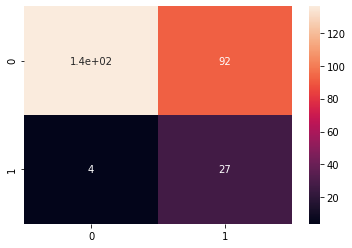

In [41]:
sns.heatmap(confusion_matrix(y_test, catboost_gs.predict(x_test)), annot=True);

In [42]:
# Смотрим какие колонки больше всего повлияли при обучении
catboost_gs.best_estimator_.feature_importances_

array([1.85033843e-01, 8.75856439e-01, 5.03914471e+00, 2.34590728e+01,
       6.56772080e+00, 2.84757723e+00, 0.00000000e+00, 2.78069702e+00,
       2.59314995e+01, 0.00000000e+00, 0.00000000e+00, 1.08209863e+00,
       1.44744525e+00, 2.51531242e+00, 3.62571838e-03, 0.00000000e+00,
       0.00000000e+00, 7.21349456e-01, 0.00000000e+00, 3.16781057e+00,
       0.00000000e+00, 0.00000000e+00, 9.38102974e-01, 5.01667915e-02,
       0.00000000e+00, 1.06568091e+01, 0.00000000e+00, 0.00000000e+00,
       1.17306767e+01])

In [43]:
feature_importance = pd.DataFrame([catboost_gs.best_estimator_.feature_importances_, default_df])

In [44]:
feature_importance.T.sort_values(0, ascending=False)

,0,1
8,25.9315,Регион выдачи кредита
3,23.459073,Возраст клиента
28,11.730677,Encoded Образованность
25,10.656809,Encoded Оператор связи
4,6.567721,Пол клиента
2,5.039145,Срок кредита
19,3.167811,Encoded Пол клиента
5,2.847577,Образование клиента
7,2.780697,Наличие детей у клиента
13,2.515312,Флаг дефолта по кредиту


## Building NOT CatBoost model

In [1024]:
etc = ExtraTreesClassifier(n_estimators=50)
etc = etc.fit(x_train, y_train)
etc.feature_importances_

array([0.06283948, 0.07524918, 0.07554788, 0.06098748, 0.0720326 ,
       0.05687232, 0.01570518, 0.03096483, 0.04449349, 0.02089697,
       0.01951832, 0.02510398, 0.04457078, 0.01345777, 0.04069763,
       0.0094084 , 0.02183259, 0.06169116, 0.01704264, 0.02182988,
       0.02320248, 0.02214356, 0.01789432, 0.02345459, 0.04413175,
       0.01434714, 0.03639704, 0.00975089, 0.0179357 ])

In [1025]:
model = SelectFromModel(etc, prefit=True)
x_train_new = model.transform(x_train)
x_test_new = model.transform(x_test)
print(x_train_new.shape, x_test_new.shape) 

(1378, 12) (345, 12)


In [ ]:
xgb = XGBClassifier(

)

xgb_param_grid = {
'base_score': [0.5],
'booster': ['gbtree'],
'eval_metric': ['auc', 'aucpr'],
'gamma': [0.15, 1, 15],
'learning_rate': [0.05],
'max_depth': [3, 4, 5, 6],
'min_child_weight': [2, 4, 10],
'n_estimators': [100],
'num_parallel_tree': [8],
'reg_alpha': [5, 20],
'reg_lambda': [5, 20],
'subsample': [0.2, 0.7],
'colsample_bytree': [0.5], 
'use_label_encoder': [False]
}

xgb_gs = BayesSearchCV(
    XGBClassifier(),
    {
'base_score': [0.5, 0.25, 0.75],
'booster': ['gbtree'],
'eval_metric': ['auc', 'aucpr'],
'gamma': [0.15, 1, 15, 50],
'learning_rate': [0.001, 0.1, 0.05],
'max_depth': [3, 4, 5, 6],
'min_child_weight': [2, 4, 10],
'n_estimators': [100, 150, 300, 600, 1000],
'num_parallel_tree': [2, 8, 20, 50, 100],
'reg_alpha': [5, 20, 60],
'reg_lambda': [5, 20, 60],
'subsample': [0.2, 0.4, 0.8],
'colsample_bytree': [0.25, 0.5, 0,75, 1], 
'use_label_encoder': [False]
    },
    cv=5,
    n_jobs=-1,
    n_iter=25
)

xgb_gs.fit(x_train_new, ravel(y_train))

In [ ]:
print("val. score: %s" % xgb_gs.best_score_)
print("test score: %s" % xgb_gs.score(x_test_new, y_test))
print("best params: %s" % str(xgb_gs.best_params_))

In [ ]:
print(classification_report(y_test, xgb_gs.best_estimator_.predict(x_test_new)))

In [1026]:
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning)

In [1027]:
def _F1_eval(preds, labels):
    t = np.arange(0, 1, 0.005)
    f = np.repeat(0, 200)
    results = np.vstack([t, f]).T
    # assuming labels only containing 0's and 1's
    n_pos_examples = sum(labels)
    if n_pos_examples == 0:
        raise ValueError("labels not containing positive examples")

    for i in range(200):
        pred_indexes = (preds >= results[i, 0])
        TP = sum(labels[pred_indexes])
        FP = len(labels[pred_indexes]) - TP
        precision = 0
        recall = TP / n_pos_examples

        if (FP + TP) > 0:
            precision = TP / (FP + TP)

        if (precision + recall > 0):
            F1 = 2 * precision * recall / (precision + recall)
        else:
            F1 = 0
        results[i, 1] = F1
    return (max(results[:, 1]))

In [1028]:
def F1_eval(preds, dtrain):
    res = _F1_eval(preds, dtrain.get_label())
    return 'f1_err', 1-res

In [1032]:
xgb = XGBClassifier(
    base_score=0.25,
    booster='gbtree',
    colsample_bytree=1,
    disable_default_eval_metric=True,
    feval=F1_eval,
    gamma=15,
    learning_rate=0.1,
    max_depth=6,
    min_child_weight=4,
    n_estimators=150,
    num_parallel_tree=20,
    reg_alpha=20,
    reg_lambda=20,
    subsample=0.2,
    use_label_encoder=False

)

xgb.fit(x_train_new, ravel(y_train))

XGBClassifier(base_score=0.25, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1,
              disable_default_eval_metric=True,
              feval=<function F1_eval at 0x7f432c5cd700>, gamma=15, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=4, missing=nan, monotone_constraints='()',
              n_estimators=150, n_jobs=8, num_parallel_tree=20, random_state=0,
              reg_alpha=20, reg_lambda=20, scale_pos_weight=1, subsample=0.2,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [1033]:
print(f'Roc_auc score is {roc_auc_score(ravel(y_train), xgb.predict(x_train_new))}')
print(f'F1 score is {f1_score(ravel(y_train), xgb.predict(x_train_new))}')

print(f'Roc_auc score is {roc_auc_score(ravel(y_test), xgb.predict(x_test_new))}')
print(f'F1 score is {f1_score(ravel(y_test), xgb.predict(x_test_new))}')

Roc_auc score is 0.5
F1 score is 0.0
Roc_auc score is 0.5
F1 score is 0.0


In [1034]:
print(classification_report(y_test, xgb.predict(x_test_new)))

              precision    recall  f1-score   support

           0       0.85      1.00      0.92       294
           1       0.00      0.00      0.00        51

    accuracy                           0.85       345
   macro avg       0.43      0.50      0.46       345
weighted avg       0.73      0.85      0.78       345



In [1048]:
rfc = RandomForestClassifier(
#     'criterion' : 'gini',
#     'class_weight' : {0:1, 1:9},
#     'bootstrap' : True,
#     'min_samples_split' : 5,
#     'min_samples_leaf' : 5,
#     'max_leaf_nodes' : 6,
#     'max_features' : 'log2',
#     'max_depth' : 4,
#     'oob_score' : True,
#     'n_estimators' : 200,
#     'n_jobs' : -1,
#     'verbose' : 3
)

rfc_params={
        'criterion' : ['entropy'],
    'class_weight' : [{0:1,1:9}, {0:1,1:10}],
    'bootstrap' : [True],
    'min_samples_split' : [8, 10],
    'min_samples_leaf' : [8, 10],
    'max_leaf_nodes' : [5, 6],
    'max_features' : ['sqrt'],
    'max_depth' : [3, 5],
    'oob_score' : [True],
    'n_estimators' : [150, 200, 250],
    'n_jobs' : [-1],
    'verbose' : [3]
    
}
rfc_gs = GridSearchCV(
    estimator=rfc,
    param_grid=rfc_params,
    scoring='f1',
    cv=5,
    verbose=4,
    n_jobs=-1,
    return_train_score=True
)

rfc_gs.fit(x_train_new, y_train)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 205 tasks      | elapsed:   25.4s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:   50.6s
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:  1.1min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s


building tree 1 of 200building tree 2 of 200
building tree 3 of 200
building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200

building tree 8 of 200
building tree 9 of 200building tree 10 of 200
building tree 11 of 200

building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200building tree 20 of 200
building tree 21 of 200

building tree 22 of 200
building tree 23 of 200building tree 24 of 200
building tree 25 of 200

building tree 26 of 200
building tree 27 of 200
building tree 28 of 200building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200building tree 33 of 200

building tree 34 of 200

building tree 35 of 200building tree 36 of 200building tree 37 of 200

building tree 38 of 200

building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200bu

[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.2s finished


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True],
                         'class_weight': [{0: 1, 1: 9}, {0: 1, 1: 10}],
                         'criterion': ['entropy'], 'max_depth': [3, 5],
                         'max_features': ['sqrt'], 'max_leaf_nodes': [5, 6],
                         'min_samples_leaf': [8, 10],
                         'min_samples_split': [8, 10],
                         'n_estimators': [150, 200, 250], 'n_jobs': [-1],
                         'oob_score': [True], 'verbose': [3]},
             return_train_score=True, scoring='f1', verbose=4)

In [1049]:
rfc_gs.best_params_

{'bootstrap': True,
 'class_weight': {0: 1, 1: 9},
 'criterion': 'entropy',
 'max_depth': 3,
 'max_features': 'sqrt',
 'max_leaf_nodes': 6,
 'min_samples_leaf': 10,
 'min_samples_split': 10,
 'n_estimators': 200,
 'n_jobs': -1,
 'oob_score': True,
 'verbose': 3}

In [1050]:
print(f'Roc_auc score is {roc_auc_score(ravel(y_train), rfc_gs.best_estimator_.predict(x_train_new))}')
print(f'F1 score is {f1_score(ravel(y_train), rfc_gs.best_estimator_.predict(x_train_new))}')

print(f'Roc_auc score is {roc_auc_score(ravel(y_test), rfc_gs.best_estimator_.predict(x_test_new))}')
print(f'F1 score is {f1_score(ravel(y_test), rfc_gs.best_estimator_.predict(x_test_new))}')

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s


Roc_auc score is 0.7410353217551808
F1 score is 0.35962145110410093
Roc_auc score is 0.658563425370148
F1 score is 0.36464088397790057


[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.0s finished


In [1051]:
print(classification_report(y_test, rfc_gs.best_estimator_.predict(x_test_new)))

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s


              precision    recall  f1-score   support

           0       0.92      0.67      0.77       294
           1       0.25      0.65      0.36        51

    accuracy                           0.67       345
   macro avg       0.59      0.66      0.57       345
weighted avg       0.82      0.67      0.71       345



[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.0s finished
